<a href="https://colab.research.google.com/github/Charlee0616/Data-Mining/blob/main/K_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [60]:
iris = load_iris()

In [61]:
df = pd.DataFrame( iris.data, columns = iris.feature_names)

In [62]:
true_labels = iris.target

In [63]:
def inertia(data, centroids, labels):
  inertia = 0
  for i, point in enumerate(data):
    centroid = centroids[int(labels[i])]
    inertia += np.sum((point - centroids[int(labels[i])])**2)
  return inertia

In [64]:
def kmeansplus(df, k):
  centroids = [df[np.random.choice(range(df.shape[0]))]]
  for i in range(1, k):
    distances = np.array([min([np.linalg.norm(point - c)**2 for c in centroids]) for point in df])
    probabilities = distances / np.sum(distances)
    next_centroid = df[np.random.choice(range(df.shape[0]), p=probabilities)]
    centroids.append(next_centroid)
  return np.array(centroids)


In [65]:
def Kmeans(df, k, method = "random", max_iters=100):
  if isinstance(df, np.ndarray):
    df = pd.DataFrame(df)
  if method == "random":
    centroids = df.iloc[np.random.choice(df.shape[0], k, replace=False)]
  elif method == "picked":
    centroids = df.iloc[:k]
  elif method == "kmeans++":
    centroids = kmeansplus(df, k)
  data = df.values
  labels = np.zeros(data.shape[0])
  for i in range(max_iters):
    for idx, point in enumerate(data):
      distances = np.sqrt(np.sum((point - centroids)**2, axis=1))
      labels[idx] = np.argmin(distances)
    new_centroids = np.array([data[labels == j].mean(axis=0) for j in range(k)])
    if np.all(centroids == new_centroids):
        break
    centroids = new_centroids

    plt.figure(figsize=(8,6))
    for j in range(k):
      plt.scatter(data[labels == j, 0], data[labels == j, 1], label=f"Cluster {j+1}")
    plt.scatter(centroids[:, 0], centroids[:, 1], color = 'black', marker='X', s=200, label = "Centroids")
    plt.title(f"K-Means Clustering (Iteration {i+1})")
    plt.xlabel(df.columns[0])
    plt.ylabel(df.columns[1])
    plt.legend()
    plt.show()
  calc_inertia = inertia(data, centroids, labels)
  return centroids, labels, calc_inertia

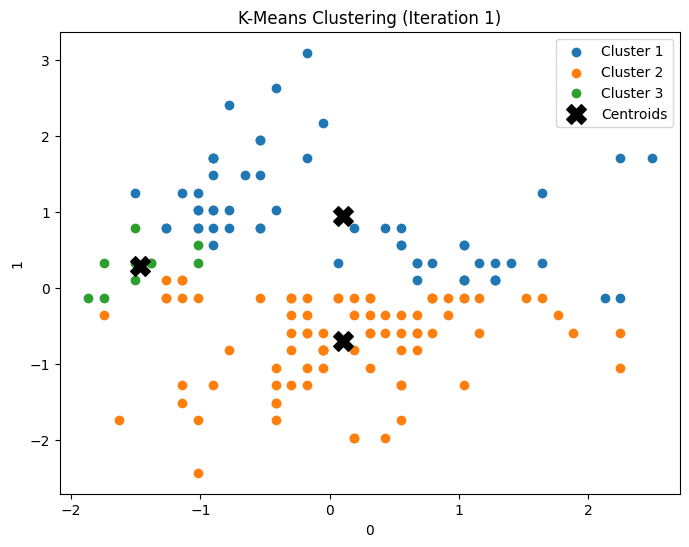

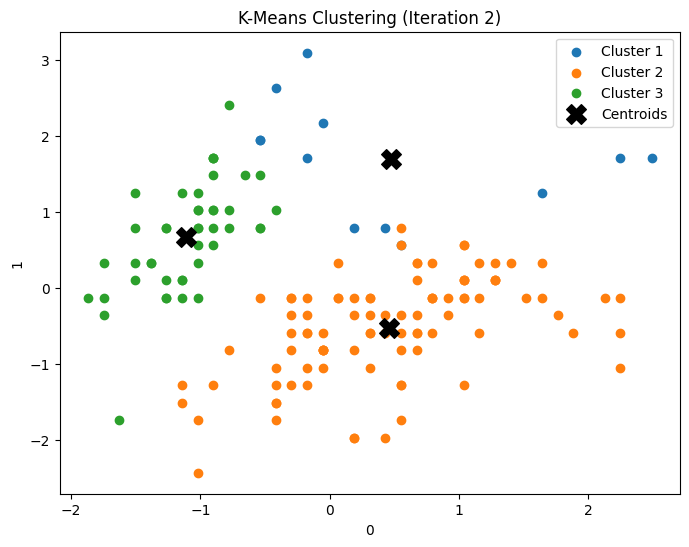

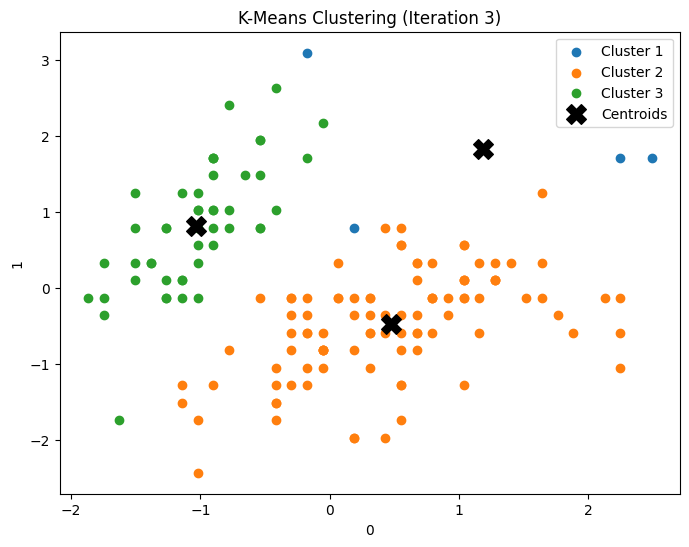

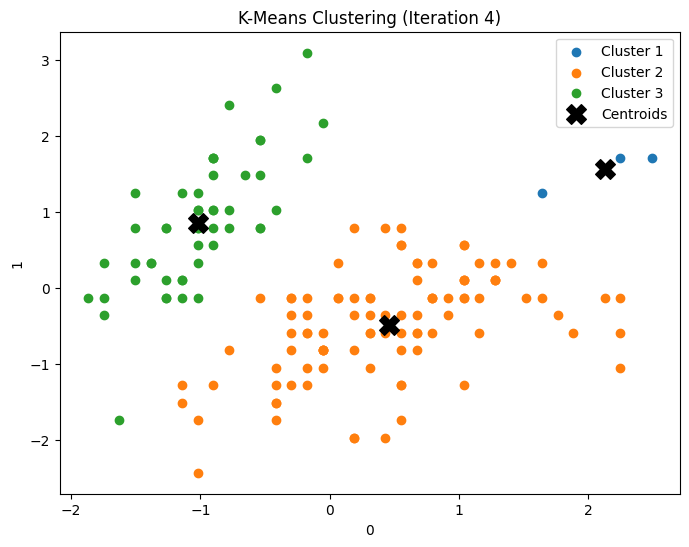

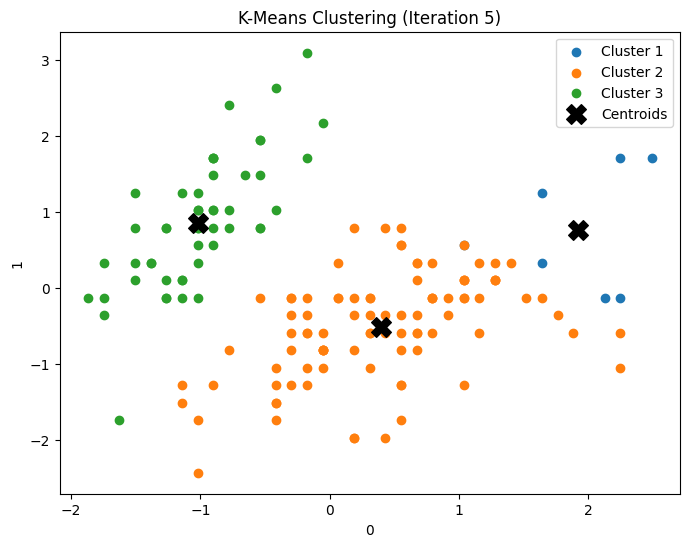

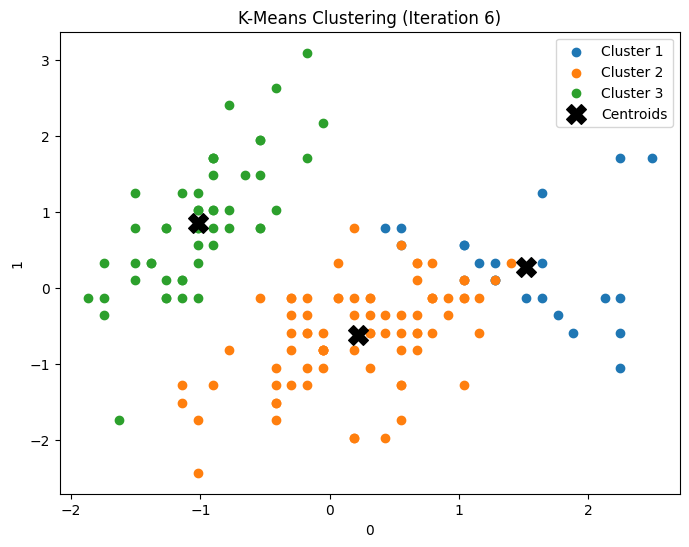

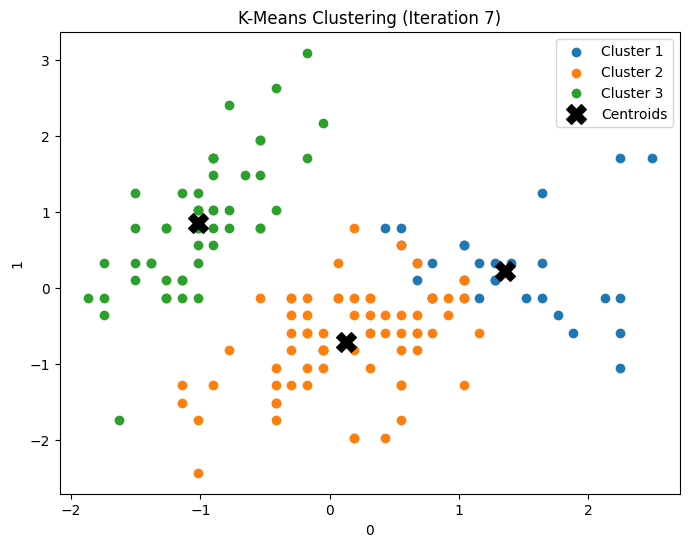

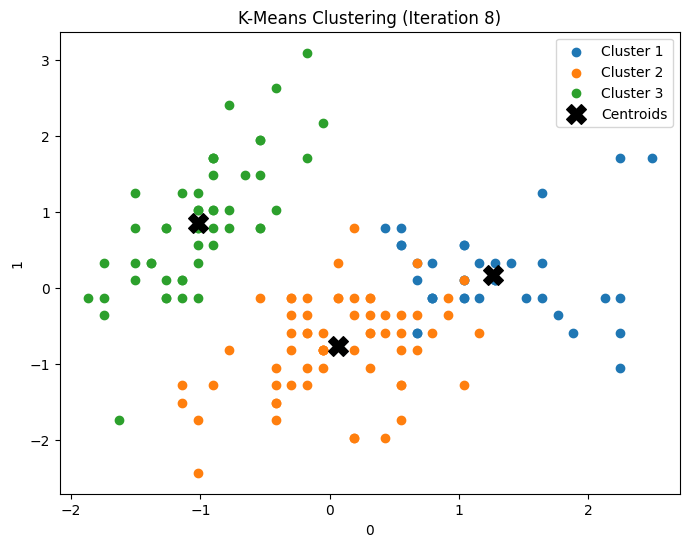

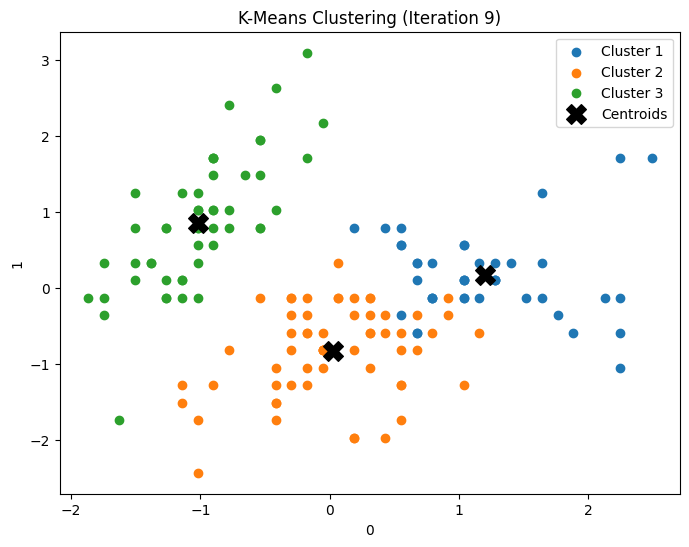

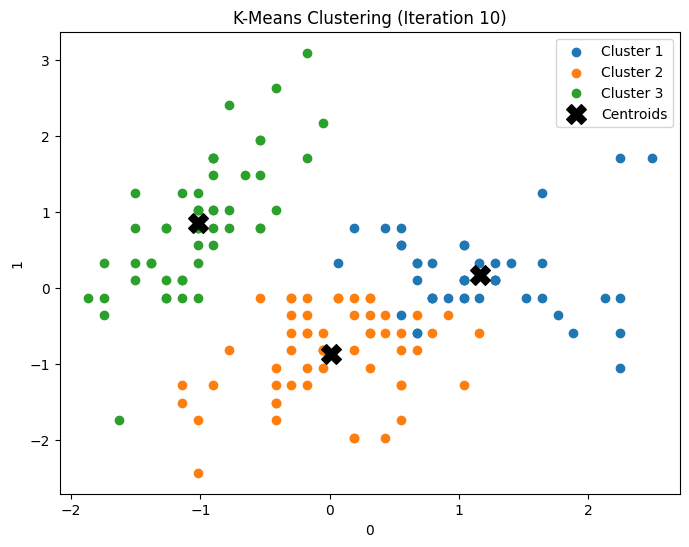

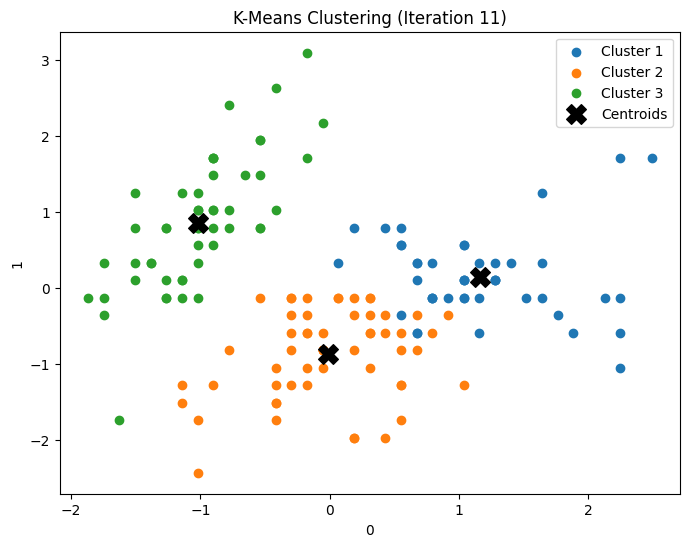

ValueError: too many values to unpack (expected 2)

In [66]:
centroids_picked, labels_picked = Kmeans(data_scaled, 3, method="picked")

In [ ]:
k = 3
centroids_random, labels_random = Kmeans(data_scaled, k, method="random")

In [ ]:
centroids_random, labels_random, inertia_random = Kmeans(data_scaled, k, method="random")
print(f"Inertia for random initialization: {inertia_random}")

In [ ]:
centroids, labels, inertia = Kmeans(data_scaled, k, method="kmeans++")
print(f"Inertia for kmeans++ initialization: {inertia}")

In [68]:
def calculate_silhouette(data, labels):
    silhouette_avg = silhouette_score(data, labels)
    sample_silhouette_values = silhouette_samples(data, labels)
    return silhouette_avg, sample_silhouette_values

In [69]:
def visualize_silhouette(data, labels):
    silhouette_avg, sample_silhouette_values = calculate_silhouette(data, labels)

    # Create a plot for silhouette scores
    plt.figure(figsize=(8, 6))
    y_lower, y_upper = 0, 0
    for i in range(len(np.unique(labels))):
        # Get silhouette scores for each cluster
        cluster_silhouette_values = sample_silhouette_values[labels == i]
        cluster_silhouette_values.sort()

        y_upper += len(cluster_silhouette_values)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, alpha=0.7)
        plt.text(-0.05, (y_lower + y_upper) / 2, f"Cluster {i+1}", va='center', ha='right')
        y_lower = y_upper

    plt.title(f"Silhouette Plot - Average Score: {silhouette_avg:.2f}")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.show()

In [75]:
visualize_silhouette(data_scaled, labels)

NameError: name 'labels' is not defined